# Docling-Graph: Complete Invoice Extraction Workflow

This notebook demonstrates a complete end-to-end workflow:
1. Extract data from an invoice image using VLM backend
2. Convert to knowledge graph
3. Export and visualize results
4. Query the graph

**Requirements:**
- Install dependencies: `pip install -e .`
- GPU recommended (but works on CPU)
- Sample invoice: `examples/Data/sample_invoice.jpg`
- Template: `examples/templates/invoice.py`

## Setup and Imports

In [14]:
# Standard library imports
from pathlib import Path
import sys

# Add examples directory to path
sys.path.insert(0, str(Path.cwd().parent))

# Docling-graph imports
from docling_graph.pipeline import run_pipeline

# Import graph module
from docling_graph.core import (
    GraphConverter,
    GraphConfig,
    CSVExporter,
    CypherExporter,
    CosmoGraphVisualizer
)

# Visualization imports
from IPython.display import Image, Markdown, HTML, display
from cosmograph import cosmo
import networkx as nx
import pandas as pd

print("All imports successful!")

All imports successful!


## Step 1: View the Source Invoice

Let's first take a look at the invoice we'll be extracting data from.

Invoice found: ..\examples\data\invoice\sample_invoice.jpg


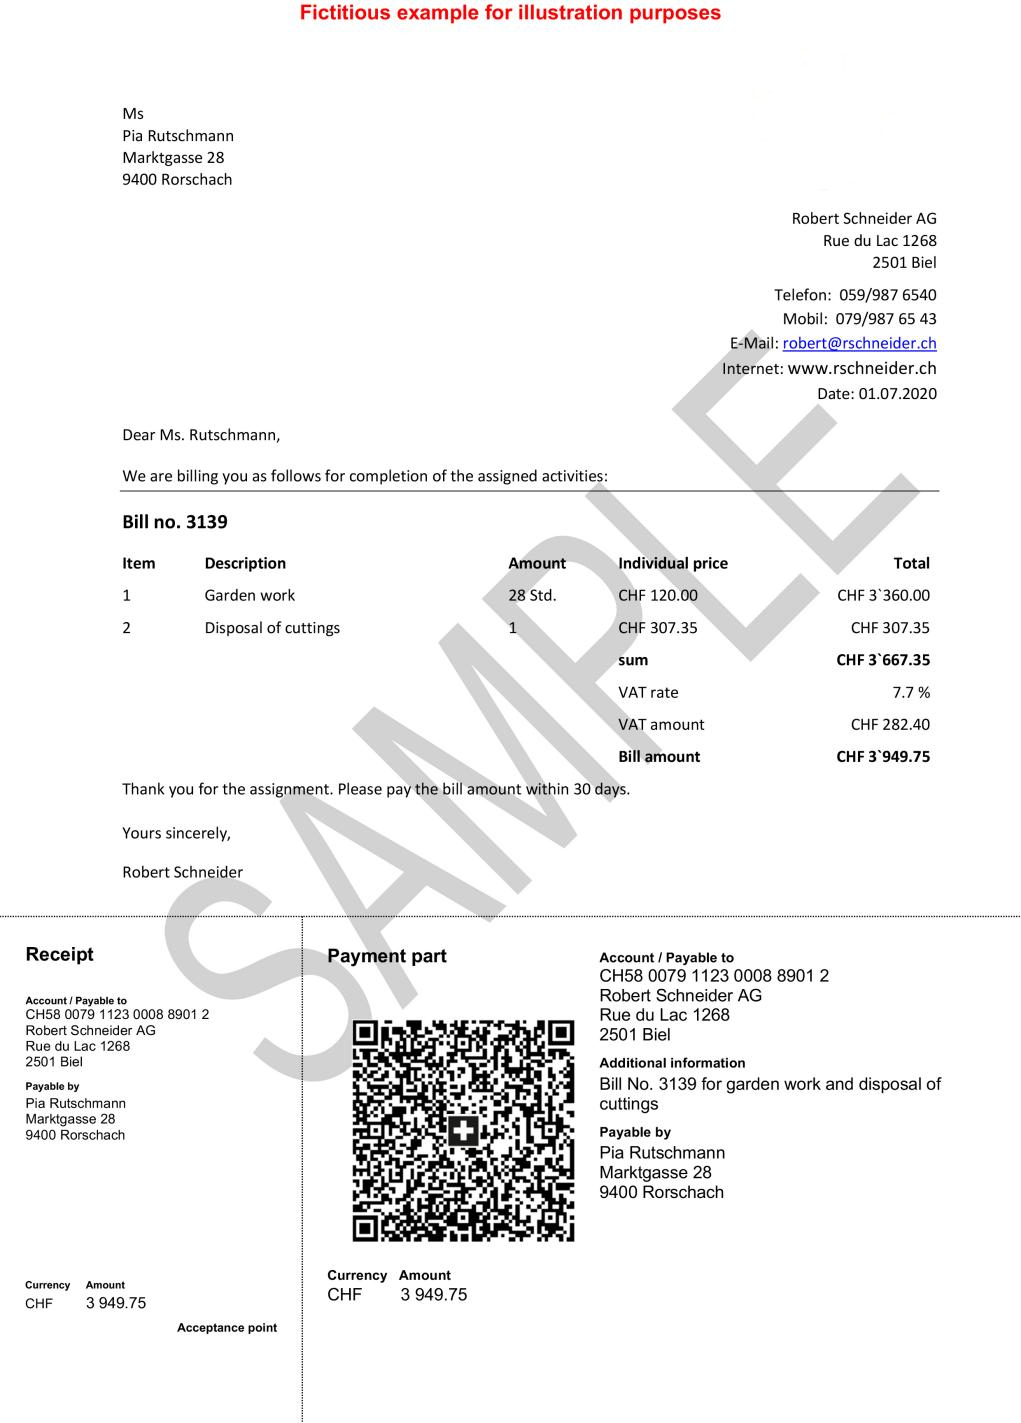

In [8]:
# Define paths
source_invoice = Path("../examples/data/invoice/sample_invoice.jpg")
template_path = "examples.templates.invoice.Invoice"
output_dir = Path("../outputs/notebook_example")

# Check if invoice exists
if not source_invoice.exists():
    print(f"Invoice not found at: {source_invoice}")
    print("Please update the path or place a sample invoice at this location")
else:
    print(f"Invoice found: {source_invoice}")
    display(Image(filename=str(source_invoice), width=600))

## Step 2: Configure the Pipeline

We'll use the **VLM (Vision-Language Model)** backend for extraction.

**Why VLM for invoices?**
- Better understanding of visual layout
- Can handle tables, logos, and complex formatting
- No OCR preprocessing needed

In [9]:
# Pipeline configuration
config = {
    # Source document
    "source": str(source_invoice),
    
    # Template (Pydantic model for invoice)
    "template": template_path,
    
    # Processing configuration
    "processing_mode": "one-to-one",  # Single page to single invoice
    "backend_type": "vlm",  # Use Vision-Language Model for extraction
    "inference": "local",  # Local inference
    "docling_config": "vision",  # VLM pipeline (not OCR)
    
    # Output configuration
    "output_dir": str(output_dir),
    "export_format": "csv",
    "reverse_edges": False,
    
    # Model configuration
    "config": {
        "models": {
            "vlm": {
                "local": {
                    "default_model": "numind/NuExtract-2.0-8B",
                    "provider": "docling"
                }
            }
        }
    },
    
    "model_override": None,
    "provider_override": None
}

# Create output directory
output_dir.mkdir(parents=True, exist_ok=True)

print("Pipeline configured:")
print(f"  Backend: {config['backend_type'].upper()}")
print(f"  Model: {config['config']['models']['vlm']['local']['default_model']}")
print(f"  Output: {output_dir}")

Pipeline configured:
  Backend: VLM
  Model: numind/NuExtract-2.0-8B
  Output: ..\outputs\notebook_example


## Step 3: Run the Extraction Pipeline

This will:
1. Load the invoice image
2. Extract data using VLM
3. Validate against Pydantic schema
4. Convert to knowledge graph (using **docling graph module**)
5. Generate visualizations and exports

**Note:** First run will download the VLM model (~8GB). Subsequent runs are faster.

In [10]:
%%time

# Run the pipeline
try:
    print("Starting extraction pipeline...")
    print("=" * 70)
    run_pipeline(config)
    print("\n" + "=" * 70)
    print("EXTRACTION COMPLETE!")
    print("=" * 70)
except Exception as e:
    print(f"\nError: {e}")
    raise

Starting extraction pipeline...


--- Starting Docling-Graph Pipeline ---

Loading template: examples.templates.invoice.Invoice

Successfully loaded Pydantic template: Invoice

Using model: numind/NuExtract-2.0-8B (provider: docling)

[ExtractorFactory] Creating extractor:

Mode: one-to-one

Type: vlm

Docling: vision

[VlmBackend] Initialized with model: numind/NuExtract-2.0-8B

[DocumentProcessor] Initialized with VLM pipeline

[OneToOneStrategy] Initialized with VLM backend: VlmBackend

[ExtractorFactory] Created OneToOneStrategy

[OneToOneStrategy] Using VLM backend for extraction

[VlmBackend] Extracting from: ..\examples\data\invoice\sample_invoice.jpg

c:\Users\Ayoub\miniconda3\envs\docling\Lib\site-packages\docling\document_extractor.py:144: UserWarning: The extract API is currently experimental and may change without prior notice.
Only PDF and image formats are supported.
  return next(all_res)
2025-10-29 18:02:22,689 - INFO - detected formats: [<InputFormat.IMAGE: 'image'>]
2025-10-29 18:02:22,728 - INFO - Going to extract document batch...
2025-10-29 18:02:22,729 - INFO - Initializing extraction pipeline for ExtractionVlmPipeline with options hash 1cac5e1155a033acc7f2c2022974af11
2025-10-29 18:02:22,729 - INFO - Accelerator device: 'cuda:0'


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2025-10-29 18:02:29,038 - INFO - Processing pages 1-9223372036854775807 of 1 total pages for extraction
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
2025-10-29 18:02:40,125 - INFO - Finished extracting document sample_invoice.jpg in 17.44 sec.


[VlmBackend] Extracted 1 valid items

Successfully extracted 1 item(s).

Converting Pydantic model(s) to Knowledge Graph...

Graph created with 7 nodes and 6 edges.

Node types:

- Invoice: 1

- Issuer: 1

- Address: 2

- Client: 1

- LineItem: 2

Exporting graph data in CSV format...

-> Saved CSV files to ..\outputs\notebook_example

-> Generating visualizations...

-> Generated markdown report

Graph Statistics:

Nodes: 7

Edges: 6

Creating CosmoGraph visualization...

Exporting to HTML...

[GraphInspector] HTML file created: ..\outputs\notebook_example\sample_invoice_graph.html

To view, open: ..\outputs\notebook_example\sample_invoice_graph.html

-> Generated CosmoGraph interactive visualization

--- Pipeline Finished Successfully! ---

Cleaning up resources...

[VlmBackend] Cleaned up resources and GPU memory

[DocumentProcessor] Cleaned up resources


EXTRACTION COMPLETE!
CPU times: total: 17.3 s
Wall time: 18.1 s


## Step 4: Review Generated Outputs

The pipeline has generated several output files using the **graph module**. Let's explore them.

In [11]:
# List generated files
output_files = sorted(output_dir.glob("*"))

print("Generated files:")
print("=" * 70)
for file in output_files:
    size = file.stat().st_size
    size_kb = size / 1024
    print(f" {file.name:40s} ({size_kb:>8.2f} KB)")

print(f"\nTotal files: {len(output_files)}")

Generated files:
 edges.csv                                (    0.34 KB)
 nodes.csv                                (    0.78 KB)
 sample_invoice_graph.html                ( 1346.58 KB)
 sample_invoice_graph.md                  (    1.99 KB)

Total files: 4


## Step 5: Display the Markdown Report

The pipeline generates a detailed markdown report with extraction results using **ReportGenerator**.

In [12]:
# Find and display the markdown report
md_files = list(output_dir.glob("*.md"))

if md_files:
    md_file = md_files[0]
    print(f"Markdown Report: {md_file.name}\n")
    print("=" * 70)
    
    with open(md_file, 'r', encoding='utf-8') as f:
        md_content = f.read()
    
    display(Markdown(md_content))
else:
    print("No markdown report found")

Markdown Report: sample_invoice_graph.md



# Knowledge Graph Report

Automatically generated by docling-graph.

## Overview

- **Total Nodes**: 7
- **Total Edges**: 6
- **Source Models**: 1
- **Generated**: 2025-10-29 17:02:40

## Node Type Distribution

| Node Type | Count | Percentage |
|-----------|-------|------------|
| Address | 2 | 28.6% |
| LineItem | 2 | 28.6% |
| Invoice | 1 | 14.3% |
| Issuer | 1 | 14.3% |
| Client | 1 | 14.3% |

## Edge Type Distribution

| Edge Type | Count | Percentage |
|-----------|-------|------------|
| contains_items | 2 | 33.3% |
| issued_by | 1 | 16.7% |
| sent_to | 1 | 16.7% |
| located_at | 1 | 16.7% |
| lives_at | 1 | 16.7% |

## Sample Nodes

### Node: Invoice_185927c4c83e

- **Label**: Invoice
- **Type**: entity
- **Bill No**: 3139
- **Date**: 2020-07-01
- **Currency**: CHF
- **Subtotal**: 3667.35
- **Vat Rate**: 7.7
- **Vat Amount**: 282.4
- **Total**: 3949.75

### Node: Issuer_4eb31ef72925

- **Label**: Issuer
- **Type**: entity
- **Name**: Robert Schneider AG
- **Phone**: 059/987 6540
- **Email**: robert@rschneider.ch
- **Website**: www.rschneider.ch

### Node: Address_9ba10e8de54a

- **Label**: Address
- **Type**: entity
- **Street**: Rue du Lac 1268
- **Postal Code**: 2501
- **City**: Biel
- **Country**: None

### Node: Client_ea59d3c98a4c

- **Label**: Client
- **Type**: entity
- **Name**: Ms Pia Rutschmann
- **Phone**: None
- **Email**: None
- **Website**: None

### Node: Address_08e82d251960

- **Label**: Address
- **Type**: entity
- **Street**: Marktgasse 28
- **Postal Code**: 9400
- **City**: Rorschach
- **Country**: None


## Sample Edges

### Invoice_185927c4c83e → Issuer_4eb31ef72925
**Type**: issued_by

### Invoice_185927c4c83e → Client_ea59d3c98a4c
**Type**: sent_to

### Invoice_185927c4c83e → LineItem_d9c5c2664848
**Type**: contains_items

### Invoice_185927c4c83e → LineItem_442329871fe5
**Type**: contains_items

### Issuer_4eb31ef72925 → Address_9ba10e8de54a
**Type**: located_at


## Step 6: View Interactive Graph (HTML)

The interactive HTML visualization (created by **CosmoGraphVisualizer**) allows you to:
- Drag and rearrange nodes
- Zoom in/out
- Click nodes to see details
- Explore relationships

In [27]:
# Read CSV files
nodes_csv = output_dir / "nodes.csv"
edges_csv = output_dir / "edges.csv"

# Load the data
nodes_df = pd.read_csv(nodes_csv)
edges_df = pd.read_csv(edges_csv)

# Get all column names except 'id' (which is already used for point_id_by)
additional_columns = [col for col in nodes_df.columns if col != 'id']

# Create and display the widget inline with tooltips
widget = cosmo(
    points=nodes_df,
    links=edges_df,
    point_id_by='id',
    link_source_by='source',
    link_target_by='target',
    point_label_by='id',
    point_include_columns=additional_columns,
    fit_view_delay=2000
)

widget

Cosmograph(background_color=None, components_display_state_mode=None, fit_view_delay=2000.0, focused_point_rin…

## Step 7: Load and Analyze the Knowledge Graph

Now let's load the graph into NetworkX and perform some analysis.

**Display Nodes Data**

In [ ]:
# Read nodes CSV (generated by CSVExporter)
nodes_csv = output_dir / "nodes.csv"

if nodes_csv.exists():
    nodes_df = pd.read_csv(nodes_csv)
    
    print("EXTRACTED DATA - NODES")
    print("=" * 70)
    print(f"\nTotal Nodes: {len(nodes_df)}\n")
    
    # Display nodes (drop empty columns, replace NaN with empty string)
    nodes_display = nodes_df.dropna(axis=1, how='all').fillna('')
    display(nodes_display)
else:
    print(f"Nodes CSV file not found at: {nodes_csv}")

EXTRACTED DATA - NODES

Total Nodes: 7



,id,label,type,bill_no,date,currency,subtotal,vat_rate,vat_amount,total,...,phone,email,website,street,postal_code,city,description,quantity,unit,unit_price
0,Invoice_9a0f3db8fdbe,Invoice,entity,3139.0,01.07.2020,CHF,3667.35,7.7,282.4,3949.75,...,,,,,,,,,,
1,Issuer_cbde7c22ccff,Issuer,entity,,,,,,,,...,059/987 6540,robert@rschneider.ch,www.rschneider.ch,,,,,,,
2,Address_e1310a233dad,Address,entity,,,,,,,,...,,,,Rue du Lac 1268,2501.0,Biel,,,,
3,Client_f7aff41677fa,Client,entity,,,,,,,,...,,,,,,,,,,
4,Address_440085a1073f,Address,entity,,,,,,,,...,,,,Marktgasse 28,9400.0,Rorschach,,,,
5,LineItem_09179e37999d,LineItem,entity,,,,,,,3360.0,...,,,,,,,Garden work,28.0,Std.,120.0
6,LineItem_337ce9d620c7,LineItem,entity,,,,,,,307.35,...,,,,,,,Disposal of cuttings,1.0,,307.35


**Display Relationships Data**

In [ ]:
# Read edges CSV (generated by CSVExporter)
edges_csv = output_dir / "edges.csv"

if edges_csv.exists():
    edges_df = pd.read_csv(edges_csv)
    
    print("EXTRACTED DATA - RELATIONSHIPS")
    print("=" * 70)
    print(f"\nTotal Relationships: {len(edges_df)}\n")
    
    # Display relationships (replace NaN with empty string)
    edges_display = edges_df.dropna(axis=1, how='all').fillna('')
    display(edges_display)
else:
    print(f"Edges CSV file not found at: {edges_csv}")


EXTRACTED DATA - RELATIONSHIPS

Total Relationships: 6



,source,target,label
0,Invoice_9a0f3db8fdbe,Issuer_cbde7c22ccff,issued_by
1,Invoice_9a0f3db8fdbe,Client_f7aff41677fa,sent_to
2,Invoice_9a0f3db8fdbe,LineItem_09179e37999d,contains_items
3,Invoice_9a0f3db8fdbe,LineItem_337ce9d620c7,contains_items
4,Issuer_cbde7c22ccff,Address_e1310a233dad,located_at
5,Client_f7aff41677fa,Address_440085a1073f,lives_at


## Step 8: Query the Graph

Let's explore what entities were extracted from the invoice.

**Load Graph into NetworkX**

In [17]:
# Read CSV files
nodes_csv = output_dir / "nodes.csv"
edges_csv = output_dir / "edges.csv"

if nodes_csv.exists() and edges_csv.exists():
    nodes_df = pd.read_csv(nodes_csv)
    edges_df = pd.read_csv(edges_csv)
    
    print("LOADING GRAPH INTO NETWORKX")
    print("=" * 70)
    
    graph = nx.DiGraph()
    
    # Add nodes
    for _, node in nodes_df.iterrows():
        node_id = node['id']
        node_dict = node.to_dict()
        graph.add_node(node_id, **node_dict)
    
    # Add edges
    for _, edge in edges_df.iterrows():
        source = edge['source']
        target = edge['target']
        edge_dict = edge.to_dict()
        graph.add_edge(source, target, **edge_dict)
    
    print(f"\nGraph loaded into NetworkX")
    print(f" Nodes: {graph.number_of_nodes()}")
    print(f" Edges: {graph.number_of_edges()}")
    
    # Show node types
    node_types = {}
    for node_id, data in graph.nodes(data=True):
        label = data.get('label', 'Unknown')
        node_types[label] = node_types.get(label, 0) + 1
    
    print(f"\nNode Types:")
    for label, count in node_types.items():
        print(f" • {label}: {count}")

else:
    print("CSV files not found")
    graph = None

LOADING GRAPH INTO NETWORKX

Graph loaded into NetworkX
 Nodes: 7
 Edges: 6

Node Types:
 • Invoice: 1
 • Issuer: 1
 • Address: 2
 • Client: 1
 • LineItem: 2


**Find Entities by Type**

In [18]:
if graph:
    # Group nodes by type (label)
    node_types = {}
    for node_id, data in graph.nodes(data=True):
        label = data.get('label', 'Unknown')
        if label not in node_types:
            node_types[label] = []
        node_types[label].append((node_id, data))
    
    print("Entities by Type:")
    print("=" * 70)
    
    for label, nodes in node_types.items():
        print(f"\n{label} ({len(nodes)} node(s)):")
        for node_id, data in nodes:
            print(f" • {node_id}")
            # Show some key properties
            for key, value in data.items():
                if key not in ['id', 'label'] and value and str(value) != 'nan':
                    print(f"   - {key}: {value}")

Entities by Type:

Invoice (1 node(s)):
 • Invoice_9a0f3db8fdbe
   - type: entity
   - bill_no: 3139.0
   - date: 01.07.2020
   - currency: CHF
   - subtotal: 3667.35
   - vat_rate: 7.7
   - vat_amount: 282.4
   - total: 3949.75

Issuer (1 node(s)):
 • Issuer_cbde7c22ccff
   - type: entity
   - name: Robert Schneider AG
   - phone: 059/987 6540
   - email: robert@rschneider.ch
   - website: www.rschneider.ch

Address (2 node(s)):
 • Address_e1310a233dad
   - type: entity
   - street: Rue du Lac 1268
   - postal_code: 2501.0
   - city: Biel
 • Address_440085a1073f
   - type: entity
   - street: Marktgasse 28
   - postal_code: 9400.0
   - city: Rorschach

Client (1 node(s)):
 • Client_f7aff41677fa
   - type: entity
   - name: Ms Pia Rutschmann

LineItem (2 node(s)):
 • LineItem_09179e37999d
   - type: entity
   - total: 3360.0
   - description: Garden work
   - quantity: 28.0
   - unit: Std.
   - unit_price: 120.0
 • LineItem_337ce9d620c7
   - type: entity
   - total: 307.35
   - descrip